In this chapter, we will be using the MNIST dataset (set of 70,000 small images of digits handwritten). Each image is labeled with the digit it represents.

Let's download this popular dataset via Scikit-learn

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist["data"], mnist["target"]

There are 70,000 images and each image has 784 features (bc 28x28 pixels/image and each feature represents one pixel's intensity from 0 to 255)

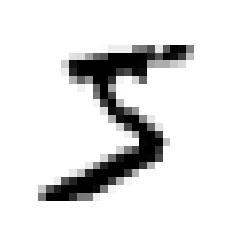

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt 

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

Let's cast y to integers because there are labels (string)

In [4]:
import numpy as np

y = y.astype(np.uint8)

Let's split the dataset and set aside the test set before inspecting the data closely

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[10000:], y[:60000], y[10000:]

## Training a binary Classifier 

Let's simplify the problem for now and only try to identify one digit (the number 5 for example).

In [6]:
y_train_5 = (y_train == 5) # true for all 5s and false otherwise
y_test_5 = (y_test == 5)

Let's begin with a Stochastic Gradient Descent (SGD) classifier. This classifier has the advantage of being capable of handling very large dataset efficiently. Because SGD deals with training instances independantly, one at time (so well suited for online learning)

In [7]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

array([False])

## Performance Measures

### Measuring accuracy using cross-validation

A good way to evaluate a model is to use cross-validation

#### Implementing Cross-Validation  

Let's implement cross-validation yourself (cross_val_score() from scikit-learn) because you will need more control. 

In [8]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone 

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

0.9604
0.94815
0.9615


(*) The StratifiedKFold class performs stratified sampling to produce folds that contain a representative ratio of each class. At each iteration the code creates a clone of the classifier, trains that clone on the training folds and makes predictions on the test fold. Then it counts the number of correct predictions and outputs the ratio of correct predictions

In [9]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9592 , 0.96455, 0.95615])

WoW! Above 95% accuracy (ratio of correct predictions) on all cross-validation folds? 

When you create a dumb classifier that classifies all the images not 5, we obtain a 90% accuracy. It's normal because there are only 10% of images that are 5s in the dataset. <br> This demonstrates why accuracy is generally not the preferred performance measure

#### Confusion matrix

A much better way to evaluate the performance of a classifier to look at the _confusion matrix_. The general idea is to count the number of times instances of class A are classified as class B. 

To compute the confusion matrix, you first need to have a set of predictions, so they can be compared to the actual targets. 

In [10]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Cross_val_predict performs K-fold cross validation and returns the predictions instead of evaluation scores made on each test fold.

In [11]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53953,   626],
       [ 1682,  3739]])

Each row represents an _actual class_ while each column represents a _predicted class_. The following image illustrates correctly confusion matrix. <br>
Note that a perfect classifier has 0 on his opposite diagonal

![title](img/confusion_matrix.png)

An interesting one to look at is the accuracy of the positive predictions. $precision = \frac{TP}{TP + FP}$

Another measure of precison is __recall__. This is the ratio of positive instances that are correctly detected by the classifier<br>
$recall = \frac{TP}{TP+FN}$

In [12]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8565864833906071

In [13]:
recall_score(y_train_5, y_train_pred)

0.689725142962553

When it claims an image represents a 5, it's correct only 71,5%  of the time. Moreover, it only detects 84% of the 5s

It's often convenient to combine precision and recall into a single metric called $F_{1}$. This is the __harmonic mean__ of precision and recall. The harmonic mean gives more weight to low values (whereas regular means treats all values equally). A classifier will only get a high $F_{1}$ if both recall and precision are high. 
$F_{1} = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = \frac{TP}{TP + \frac{FN + FP}{2}}$

In [14]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7641528714490087

The F1 score favors classifiers that have similar precision and recall. But this is not always what you want. 

Increasing precision reduces recall and vice-versa. This is called __precision/recall tradeoff__

####  Precision/recall tradeoff

Let's look how the SGDClassifer makes its classification decisions. For each instance, it computes a score based on a _decision function_, and if that score is greater than a threshold, it assigns the instance to the positive class or else to the negative class. 
![title](img/decision_threshold.png)

Now how do you decide which threshold to use? <br>
For this, you will first need to get the scores of all instances in the training set using _cross_val_predict()_ function specifying that you want to retun decision scores

In [15]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

Now with these scores, you can compute precision and recall for all possible thresholds

In [16]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

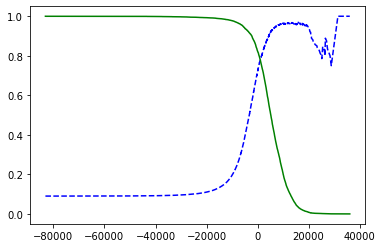

In [17]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

The choice of precision/recall depends on your project. If for example, you want 90% precision

In [18]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

y_train_pred_90 = (y_scores >= threshold_90_precision)

precision_score(y_train_5, y_train_pred_90)

0.9000593119810202

Warning !! A high-precision classifier is not very useful if its recall is too low

### The ROC curve

The __receiver operating characteristic (ROC)__ curve is another common tool used with binary classifiers. The ROC curve plots the _true positive rate (recall)_ against the _false positive rate_. The FPR is the ratio of negative instances that are incorrectly classified as positive. <br>FPR = 1 - TNR.<br> TNR is called specifity. Hence the ROC curve plots __sensitivity__ (recall) versus __1 - specificity__

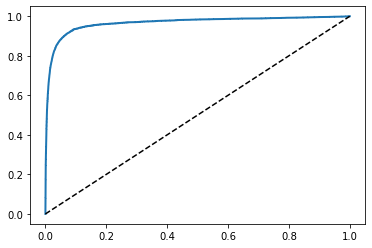

In [19]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    
plot_roc_curve(fpr, tpr)
plt.show()

There is again a tradeoff: the higher the recall (TPR), the more false positives (FPR) the classifier produces.<br>
The dotted line represents the ROC curve of a purely random classifier, a good classifier stays as far away from that line as possible (toward the top-left corner)

One way to compare classifiers is to measure the _area under the curve_ (AUC). A perfect classifier will have a ROC AUC equal to 1.

In [20]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9655496875263193

As a rule of thumb, you should prefer the PR (precision/recall) curve whenever the positive class is rare or when you care more about the false positives than the false negatives, and the ROC curve otherwise.

Let's train a __RandomForestClassifier__ and compare to the SGDClassifier

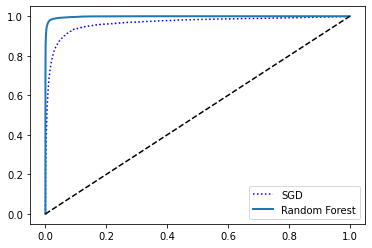

In [21]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

y_scores_forest = y_probas_forest[:,1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [22]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [25]:
y_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

In [27]:
recall_score(y_train_5, y_pred_forest)

0.8662608374838591

In [28]:
precision_score(y_train_5, y_pred_forest)

0.9905083315756169

## Multiclass Classification 

Whereas binary classifiers distinguish between two classes, multiclass classifiers can distinguish between more than 2 classes

Some algorithms (such as Random Forest classifiers or naive bayes classifiers) are capable of handling multiple classes directly. Others (such as SVM, Linear classifiers) are strictly binary classifiers. There are various strategies that you can use to perform multiclass classification using multiple binary classifiers.

For example, one way to create a system tha can classify the digit images into 10 classes is to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, ...). And when you want to classify an image, you get the decision score from each classifier and select the class whose classifier outputs the highest score. This is called __one-versus-all (OvA)__

Another strategy is to train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another 0s and 2s, another 1s and 2s and so on. This is called __one-versus-one (OvO)__. If there N classes, you need to train $\frac{N * (N-1)}{2}$ classifiers

Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task and run automatically OvA (except SVM)

In [30]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [32]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-19634.09094687, -34113.41435535, -14094.11204002,
            84.73926878, -23350.39106531,     61.30657174,
        -21209.32457749,  -9028.74610729,  -8183.92496129,
         -9025.8030674 ]])

In [33]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [34]:
sgd_clf.classes_[np.argmax(some_digit_scores)]

3

if you want to choose what use (OvO or OvA), you can specify with Scikit-learn

In [35]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [36]:
len(ovo_clf.estimators_)

45

In [38]:
# evaluation of classifiers 
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.8488 , 0.86315, 0.86815])

It's a good score but you can do better. For example, scaling the input can improve the score 

In [39]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.89835, 0.89245, 0.90385])

## Error Analysis

Here, we will assume that you have found a promising model and you want to find ways to improve it. One way to do this is to analyze the types of errors it makes.

First you can look at the confusion matrix.

In [41]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

/Users/overstreet/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


array([[5589,    0,   21,    7,    8,   48,   37,    6,  206,    1],
       [   1, 6406,   38,   25,    4,   44,    4,    8,  197,   15],
       [  27,   27, 5263,   97,   71,   27,   66,   40,  329,   11],
       [  25,   18,  122, 5253,    2,  215,   26,   41,  355,   74],
       [  12,   14,   50,   10, 5197,   11,   36,   28,  301,  183],
       [  28,   16,   36,  171,   52, 4486,   74,   18,  477,   63],
       [  30,   16,   45,    3,   42,   99, 5557,    5,  120,    1],
       [  21,    9,   54,   30,   51,   12,    3, 5715,  154,  216],
       [  19,   61,   48,   91,    3,  127,   25,   11, 5416,   50],
       [  25,   20,   30,   68,  124,   35,    1,  187,  314, 5145]])

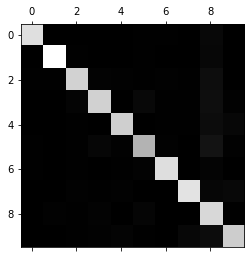

In [42]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

This confusion matrix looks fairly good. The 5s look slightly darker than the other, which could mean that there are fewer images of 5s in the dataset __or__ the classifier doesn't perform as well on 5s as on other digit.

Let's focus on the errors. You need to divide each value in the confusion matrix by the number of images in the corresponding class so you can compare error rates 

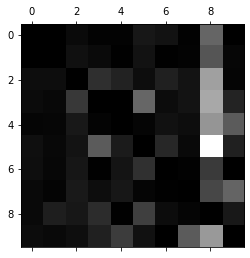

In [49]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
row_sums
norm_conf_mx = conf_mx / row_sums

# fill the diag with zeros to keep only the errors
np.fill_diagonal(norm_conf_mx, 0)

plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Remember that rows represent actual classes, while columns represent predicted classes. The column for class 8 is quite bright, which tells you that many images get misclassified as 8s. However, the row for class 8 is not that bad, telling you that actual 8s in general get properly classified as 8s.

Analyzing individual errors can also be a good way to gain insights on what your classifier is doing and why it is failing

## Multilabel Classification 

Until now each instance has always been assigned to just one class. In some cases, you may want your classifier to output multiple classes for each instance (example: face-recognition on picture with several people). It's is like a classification system that outputs multiple binary tags (__multilabel classification system__)

In [19]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [20]:
knn_clf.predict([some_digit])


array([[False,  True]])

There are many ways to evaluate a multilabel classifier. One approach is to measure the F1 score for each individual label then simply compute the average score.

In [53]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

f1_score(y_multilabel, y_train_knn_pred, average="macro")

KeyboardInterrupt: 

This assume that all labels are equally important. If this is not the case (you have many labels in one side), you can just set average to _"weighted"_. 

## Multioutput Classification

It's simply a generalization of multilabel classification where each label can be multiclass 

To illustrate this, let's build a system that removes noise from images. <br> It will take as input a noisy digit image and it will ouput a clean digit image, represented as an array of pixel intensities just like the MNIST images. 

In [54]:
# adding noise 
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise 
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise 
y_train_mod = X_train
y_test_mod = X_test

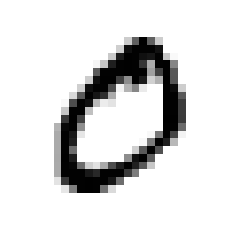

In [55]:
some_digit = X_train[1]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

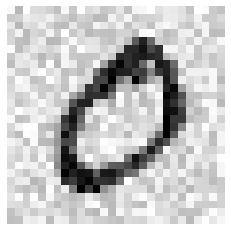

In [56]:
some_digit_mod = X_test_mod[1]
some_digit_image_mod = some_digit_mod.reshape(28, 28)

plt.imshow(some_digit_image_mod, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [60]:
knn_clf.fit(X_train_mod, y_train_mod)

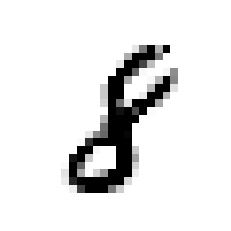

In [65]:
some_index = 1
clean_digit = knn_clf.predict([X_test_mod[some_index]])
image = clean_digit.reshape(28, 28)
plt.imshow(image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

# Exercises

#### 1) Try to build a classifier for the MNIST with 97% accuracy on the test set 

Let's use the KNeighorsClassifier (because it works well at this task). You need to find good hyperparameter values (using a grid search on the weights and n_neighbors hyperparameters)

__Warning__: the next cell may take close to 16 hours to run, or more depending on your hardware.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_neighbors' : [2, 3], 'weights' : ['uniform', 'distance']}
]

knn_clf = KNeighborsClassifier()

grid_search = GridSearchCV(knn_clf, param_grid, cv=3, scoring="accuracy", verbose=3)

grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

Best estimator from the correction is __n_neighbors = 4 and weights = distance__

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)

accuracy_score(y_test, y_pred)